<a href="https://colab.research.google.com/github/tendai-codes/DeepLearning/blob/main/Linear%2CNon_linear_and_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision

# Import matplotlib for visualization
import matplotlib.pyplot as plt

### Create device agnostic code


In [ ]:
# Setup device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cpu


# Getting a dataset
- Dataset was taken from torchvision.datasets

https://docs.pytorch.org/vision/main/datasets.html

In [ ]:
# Setup training data
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=torchvision.transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 300kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.63MB/s]


###Investigate data

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# See first training sample
image, label = train_data[0]

In [ ]:
print(label)

9


In [ ]:
print(image)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [ ]:
# See classes of data
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Labels and their corresponding index

class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# Check shape of our Image

image.shape , label
print(f"Image shape: {image.shape} -> [colour_channels, height, width]")
print(f"Image label: {class_names[label]}")


Image shape: torch.Size([1, 28, 28]) -> [colour_channels, height, width]
Image label: Ankle boot


### Visualise the data

Image shape: torch.Size([1, 28, 28])


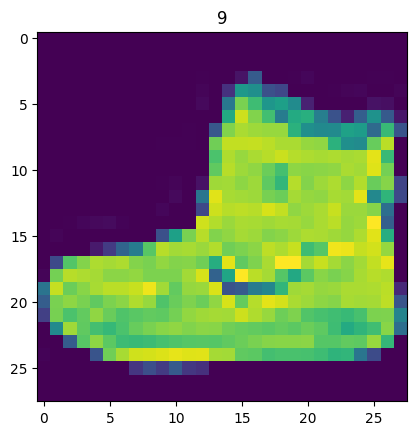

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width) matplotlib doesn't recognise so squeeze function is used to remove 1 dimension
plt.title(label);

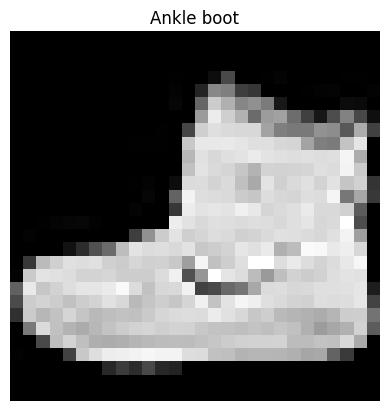

In [ ]:
# Observe image in grayscale (Use the cmap parameter)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False); #remove axes

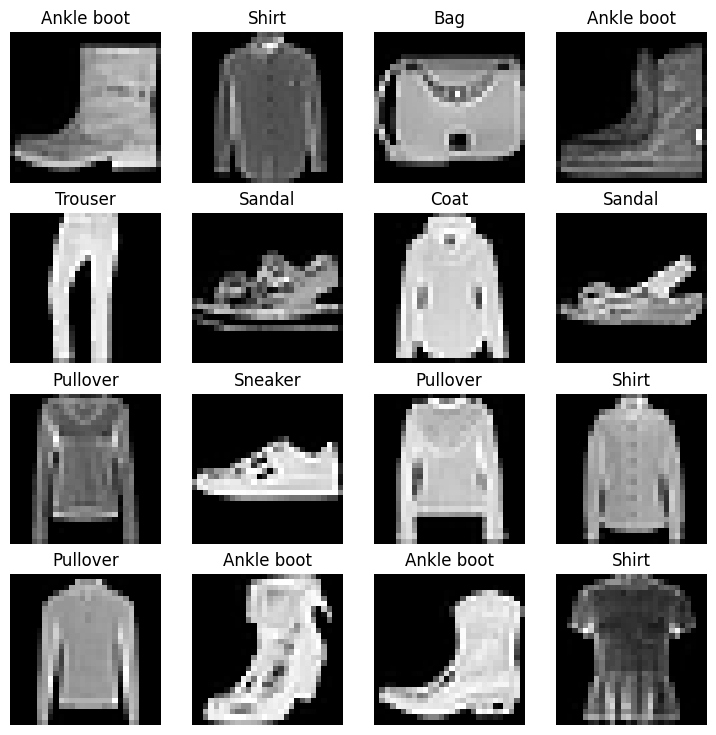

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

### Prepare Dataloader

1. Turns dataset into a python iterable (turn data into batches/mini batches)
* We do this as it is more computationally efficient as computer hardware may not have enough memory to store/look ar 60000 images at a time.
* We normally break them down into batch sizes of 32

2. It gives neural networks more chances to update its gradients per epoch

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              shuffle=True) # shuffle data so model doesn't evaluate order


test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # don't necessarily have to shuffle the testing data
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b9a385e1510>,
 <torch.utils.data.dataloader.DataLoader at 0x7b9a385ff750>)

In [ ]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b9a385e1510>, <torch.utils.data.dataloader.DataLoader object at 0x7b9a385ff750>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


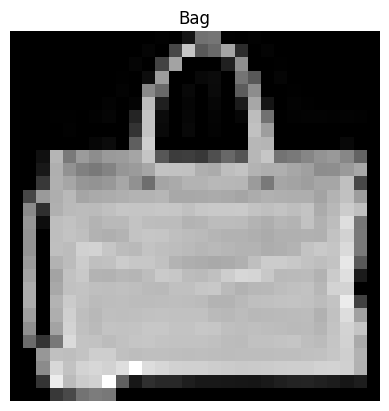

In [ ]:
# Show a sample of Batch
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


## Build a baseline model

* You use the baseline as a starting point and try to improve upon it with subsequent, more complicated models.
* When working with images we use the flatten layer -> nn.Flatten()
* It **compresses** the dimensions of a tensor into a **single vector**.

In [ ]:
# Starting off with linear model

from torch import nn
class ImageModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
        )

    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

In [ ]:
# Create an instance of model_0
torch.manual_seed(42)

# Setup model with input parameters
model_0 = ImageModelV0(
    input_shape=784, # output of the flatten layer after 28*28 image goes in
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names)).to(device) # one for every class

model_0

ImageModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Create Loss function & Accuracy metric

In [ ]:
# Calculate accuracy
def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Timing experiments & Progress Bar

In [ ]:
# Creating a function to time our experiments

from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Import tqdm for progress bar
from tqdm.auto import tqdm

### Create Training and Testing Loops (Model_0)

In [ ]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader): #features-X, labels-y
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_function(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device)
)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 33.123 seconds


### Create Eval Mode Function (for making predictions & getting results)

In [ ]:
# Create Function for evaluation
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
          # Make data device agnositc
          X, y = X.to(device), y.to(device)

            # Make predictions with the model
          y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
          loss += loss_fn(y_pred, y)
          acc += accuracy_function(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
                             device=device
)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImageModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### Build model with non-linearity

In [ ]:
# Create more better model (with non-linearity)

from torch import nn
class ImageModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

In [ ]:
# Create an instance of model_1
torch.manual_seed(42)

# Need to setup model with input parameters
model_1 = ImageModelV1(input_shape=784, # output of the flatten layer after 28*28 image goes in
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names)).to(device) # one for every class

next(model_1.parameters()).device # keep model on CPU to begin with


device(type='cpu')

### Create Loss and Accuracy Function (Model_1)


In [ ]:
# Calculate accuracy
def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### Create Function for Training step

In [ ]:
### Functionizing training loop

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  """

  train_loss, train_acc = 0, 0

    #Put model into training mode
  model.train()

    #Add a loop for looping through the training batches
  for batch, (X, y) in enumerate(data_loader):
      # Send data to device (CPU/GPU)
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


### Create Function for Testing step

In [ ]:
### Functionizing testing loop
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:

  """

  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval() # put model in eval mode

    # Turn on inference context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (Outputs raw logits)
      test_pred = model(X)

      # 2. Calculate loss and accuracy
      loss = loss_fn(test_pred, y)
      acc = accuracy_function(y_true=y,
                              y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

      test_loss += loss.item()
      test_acc += acc



  # Adjust metrics and print out
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Create Training and Testing Loops (Model_1)


In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

# Create an optimization & evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_function,
               device=device
    )
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_function,
              device=device
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 1
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Epoch: 2
---------
Train loss: 0.64302 | Train accuracy: 76.43%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cpu: 34.682 seconds


In [ ]:
# Calculate model 1 results on test dataset
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_function,
                             device=device
)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImageModelV1',
 'model_loss': 0.6850009560585022,
 'model_acc': 75.01996805111821}

### Create a Convolutional Neural Network (CNN or ConvNet)

* CNN's are known for their capabilities to find patterns in visual data
* nn.Conv2d(), also known as a convolutional layer.
nn.MaxPool2d(), also known as a max pooling layer.


- The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.

- For other dimensional data (such as 1D for text or 3D for 3D objects) there's also nn.Conv1d() and nn.Conv3d().



In [ ]:
# Create a convolutional neural network
class ImageModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3, # how big is the square that's going over the image?
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2) # default stride value is same as kernel_size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    stride=1,
                    kernel_size=3,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    stride=1,
                    kernel_size=3,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
      )

      # Dynamically calculate flattened feature size

      with torch.no_grad():
          dummy_input = torch.randn(1, input_shape, 28, 28)  # adjust size as needed
          x = self.conv_block_1(dummy_input)
          x = self.conv_block_2(x)
          self.flattened_size = x.view(1, -1).shape[1]



      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our input data.
          nn.Linear(in_features=self.flattened_size,
                    out_features=output_shape)
      )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        #print(f"Flatten input shape: {x.shape}")
        x = self.classifier(x)
        return x

In [ ]:
len(class_names)

10

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
# Create instance of the model_2

torch.manual_seed(42)
model_2 = ImageModelV2(input_shape=1,
                       hidden_units=10,
                       output_shape=len(class_names)).to(device)

next(model_1.parameters()).device # keep model on CPU to begin with

device(type='cpu')

### Create loss function, optimizer and evaluation

In [ ]:
# Calculate accuracy
def accuracy_function(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### Training and Testing model

In [ ]:
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_2,
               data_loader=train_dataloader,      loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_function,
               device=device
    )
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_function,
              device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.60326 | Train accuracy: 78.15%
Test loss: 0.40083 | Test accuracy: 86.07%

Epoch: 1
---------
Train loss: 0.35608 | Train accuracy: 87.15%
Test loss: 0.34600 | Test accuracy: 87.63%

Epoch: 2
---------
Train loss: 0.31983 | Train accuracy: 88.44%
Test loss: 0.32161 | Test accuracy: 88.41%

Train time on cpu: 188.342 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_function
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImageModelV2',
 'model_loss': 0.3216072916984558,
 'model_acc': 88.40854632587859}

### Create dataframe to view results of Models

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,ImageModelV0,0.476639,83.426518
1,ImageModelV1,0.685001,75.019968
2,ImageModelV2,0.321607,88.408546


In [ ]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,ImageModelV0,0.476639,83.426518,34.420642
1,ImageModelV1,0.685001,75.019968,34.682436
2,ImageModelV2,0.321607,88.408546,188.341821


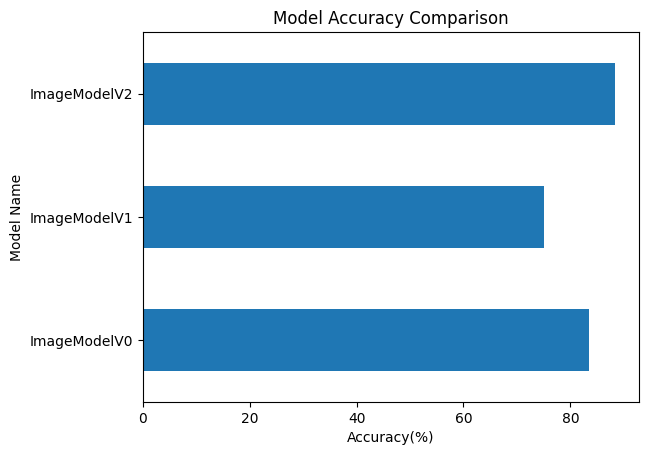

In [ ]:
# Visualise Model Results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy(%)")
plt.ylabel("Model Name")
plt.title("Model Accuracy Comparison");

### Make & Evaluate predictions using best Model

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add a batch dimension and send sample to device

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
# Make Predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
pred_probs

tensor([[8.9590e-07, 5.0991e-09, 6.9507e-09, 5.8644e-08, 3.0236e-08, 9.9997e-01,
         1.3161e-06, 3.3917e-07, 3.0135e-06, 2.0570e-05],
        [5.2429e-02, 8.0386e-01, 2.2869e-04, 9.1479e-02, 3.5980e-02, 1.9163e-04,
         1.5053e-02, 6.3763e-04, 8.3911e-05, 5.7412e-05],
        [1.1420e-05, 1.0340e-07, 9.0742e-06, 4.4687e-06, 1.9300e-06, 4.9136e-04,
         3.2211e-06, 7.9365e-01, 1.1158e-04, 2.0571e-01],
        [1.6219e-04, 7.6257e-05, 9.3435e-02, 5.9452e-04, 9.0536e-01, 3.9417e-07,
         3.5703e-04, 2.5110e-06, 3.7008e-06, 5.4120e-06],
        [3.6562e-02, 8.1311e-06, 1.6730e-05, 9.5824e-01, 2.2127e-04, 1.1671e-05,
         4.8492e-03, 1.5908e-05, 6.1465e-05, 1.8259e-05],
        [7.2216e-01, 5.3159e-06, 2.8638e-04, 1.8544e-03, 1.8557e-03, 1.2751e-07,
         2.7343e-01, 1.8342e-06, 4.0172e-04, 4.2649e-07],
        [8.6391e-05, 5.7559e-06, 2.4613e-02, 3.4574e-06, 9.6528e-01, 1.8715e-06,
         9.1042e-03, 4.3963e-07, 9.0352e-04, 3.7810e-06],
        [6.4697e-06, 7.3960

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

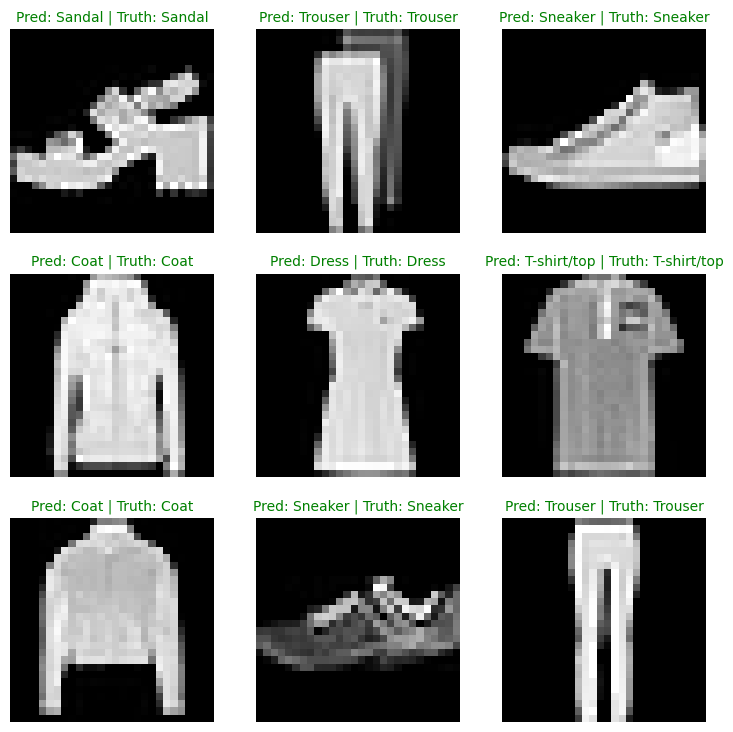

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


### Making confusion matrix






In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 5])

In [ ]:
 !pip install -q torchmetrics -U mlxtend #-U is for upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 602.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00


In [ ]:
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


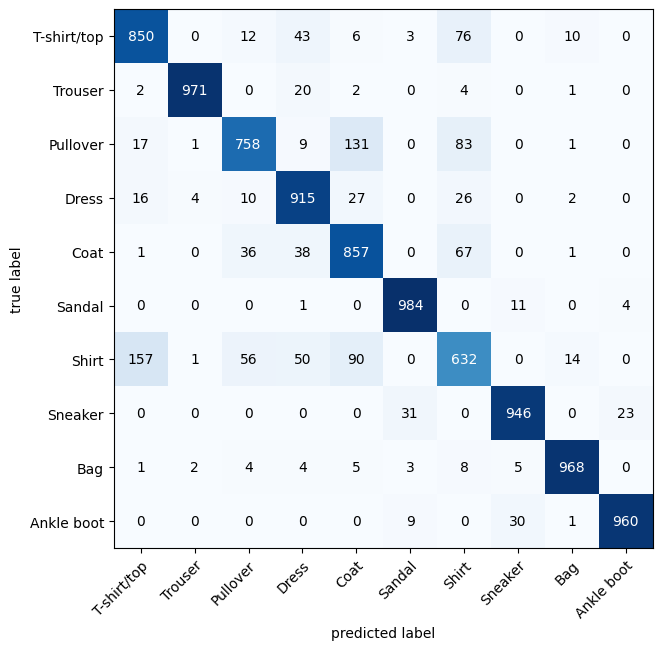

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

### Save model


In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


### Load model

In [ ]:
# Create a new instance of ImageModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = ImageModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to target device GPU
loaded_model_2 = loaded_model_2.to(device)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_function
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImageModelV2',
 'model_loss': 0.3216072916984558,
 'model_acc': 88.40854632587859}

In [ ]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-03, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)